# Getting started with the eemeter library

This jupyter notebook is an interactive tutorial. It walks through loading data, running the CalTRACK methods, and plotting results. You'll run all the code yourself. Cells can be executed with `<shift><enter>`. If you feel so inspired, make edits to the code in these cells and dig deeper.

### Note on tutorial scope

This tutorial assumes the reader has properly installed python and the eemeter package (`pip install eemeter`) and has a basic working knowledge of python syntax and usage.

## Outline

This tutorial is a self-paced walkthrough of how to use the eemeter package. We'll cover the following:

- Background - why this library
- Loading data
- Plotting and visualization
- Filtering data to baseline or reporting periods
- Creating design matrix datasets
- Fitting baseline (and reporting) models
- Using fitted models for prediction
- Computing CalTRACK metered savings

The tutorial is focused on demonstrating how to use the package to run the CalTRACK Hourly, Daily, and Billing methods on hourly, daily, and billing meter data.

## Background and Cautions

At time of writing (Sept 2018), the OpenEEmeter, as implemented in the `eemeter` package, contains the most complete open source implementation of the [CalTRACK methods](http://www.caltrack.org/), which specify a way of calculating avoided energy use at a single meter. However, using the OpenEEmeter to calculate avoided energy use does not in itself guarantee compliance with the CalTRACK method specification. Nor is using the OpenEEmeter a requirement of the CalTRACK methods. The eemeter package is a toolkit that may help with implementing a CalTRACK compliant analysis, as it provides a particular implementation of the CalTRACK methods which consists of a set of functions, parameters, and classes which can be configured to run the CalTRACK methods and variants. Please keep in mind while using the package that the eemeter assumes certain data cleaning tasks that are specified in the CalTRACK methods have occurred *prior* to usage with the eemeter. The package will create warnings to expose errors of this nature where possible.

The eemeter package is built for flexibility and modularity. While this is generally helpful and makes it easier to use the package, one potential consequence of this for users is that without being careful to follow the both the eemeter documentation *and* the guidance provided in the CalTRACK methods, it is very possible to use the eemeter in a way that does not comply with the CalTRACK methods. For example, while the CalTRACK methods set specific hard limits for the purpose of standardization and consistency, the eemeter can be configured to edit or entirely ignore those limits. The main reason for this flexibility is that the emeter package is used not only to comply with the CalTRACK methods, but also to develop, test, and propose potential changes to those methods.

Rather than providing a single method that directly calculates avoided energy use from the required inputs, the eemeter library provides a series of modular functions that can be strung together in a variety of ways. The tutorial below describes common usage and sequencing of these functions, especially when it might not otherwise be apparent from the [API documentation](https://eemeter.openee.io/api.html).

Some new users have assumed that the eemeter package constitutes an entire application suitable for running metering analytics at scale. This is not necessarily the case. It is designed instead to be embedded within other applications or to be used in one-off analyses. The eemeter is a toolbox that leaves to the user decisions about when to use or how to embed the provided tools within other applications. This limitation is an important consequence of the decision to make the methods and implementation as open and accessible as possible.

As you dive in, remember that this is a work in progress and that we welcome feedback and contributions. To contribute, please open an [issue](https://github.com/openeemeter/eemeter/issues) or a [pull request](https://github.com/openeemeter/eemeter/pulls) on github.

### Jupyter housekeeping

*Note: these Jupyter cell magics enable some useful special features but are unrelated to eemeter.*

In [1]:
# inline plotting
%matplotlib inline

# allow live package editing
%load_ext autoreload
%autoreload 2

# Importing the eemeter library

Once the eemeter has been installed, it can be imported as shown below. The package exposes most of its API at the top level of the library, so this single import is generally sufficient.

In [2]:
import eemeter

This tutorial requires eemeter version 2.x.x. You can verify the version you have installed with the command below.

In [3]:
eemeter.get_version()

'2.0.3'

## Loading data

The three essential inputs to eemeter library functions are the following:

1. Meter data
2. Temperature data from a nearby weather station
3. Project or intervention dates

Users of the library are responsible for obtaining and formatting this data (to get weather data, see [eeweather](https://eeweather.openee.io/), which helps perform site to weather station matching and can pull and cache temperature data directly from public (US) data sources). Some samples come loaded with the library and we'll load these first to save you the trouble of loading in your own data. The simulated sample data additionally has the useful property that we can load the same underlying data in three different frequencies: hourly, daily, and billing data.

We directly use [pandas](https://pandas.pydata.org/) `DataFrame` amd `Series` objects to hold the input meter and temperature time series data, which allows us to easily take advantage of the powerful methods provided by the pandas package. Use pandas has the added advantage that usage is a bit more familiar to pythonistas who work frequently with data of this nature in python. These formats are discussed in more detail below. If working with your own data instead of these samples, please refer directly to the excellent pandas documentation for instructions for loading data (e.g., [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)). For some common cases, eemeter does come packaged with loading methods, but these will only work for particular data formats.

Useful eemeter methods for loading and manipulating data:

- [`eemeter.meter_data_from_csv`](http://eemeter.openee.io/api.html#eemeter.meter_data_from_csv): Load meter data from CSV.
- [`eemeter.temperature_data_from_csv`](http://eemeter.openee.io/api.html#eemeter.temperature_data_from_csv): Load temperature data from CSV.
- [`eemeter.meter_data_from_json`](http://eemeter.openee.io/api.html#eemeter.meter_data_from_json): Load meter data from JSON.
- [`eemeter.temperature_data_from_json`](http://eemeter.openee.io/api.html#eemeter.temperature_data_from_json): Load temperature data from JSON.
- [`eemeter.samples`](http://eemeter.openee.io/api.html#eemeter.samples): Return a list of sample data names.
- [`eemeter.load_sample`](http://eemeter.openee.io/api.html#eemeter.load_sample): Load sample data by name.
- [`eemeter.as_freq`](http://eemeter.openee.io/api/html#eemeter.as_freq): Coerce meter data into a different frequency.

*Remember: the sample data is simulated, not real!*

In [4]:
meter_data_hourly, temperature_data_hourly, metadata_hourly = \
    eemeter.load_sample('il-electricity-cdd-hdd-hourly')

meter_data_daily, temperature_data_daily, metadata_daily = \
    eemeter.load_sample('il-electricity-cdd-hdd-daily')

meter_data_billing, temperature_data_billing, metadata_billing = \
    eemeter.load_sample('il-electricity-cdd-hdd-billing_monthly')

The metadata has project start and end that we can use to determine a baseline period. All three of these have the same project dates, so we'll just use one of them. All we are using this for is to define the baseline end date and the reporting period start date.

In [5]:
baseline_end_date = metadata_billing['blackout_start_date']
baseline_end_date

datetime.datetime(2016, 12, 26, 0, 0, tzinfo=<UTC>)

### More about the meter data data structure

The convention for formatting meter data is to create a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) with a [DatetimeIndex](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html) called `start` and a single column of meter readings called `value`. The index datetime values represent the start dates of each metering period. The end of each period is the start of the next period, even for data with variable period lengths like billing data. The end date of the last period can be supplied by appending an extra period with the final end date and a NaN value. Missing data is represented by one or more periods of value NaN. Data should be sorted by time and deduplicated prior to use with eemeter. Timestamps must be timezone aware.

Data is formatted like this as a convenience to avoid the need to store a start and an end period for each data point. However, the convention that uses start dates as timestamps can be a bit confusing. Make sure that if you are starting with billing data, which is sometimes defined primarily by period end dates that the transformation is done properly so that the meter data ends up with start dates as time stamps.

Take a look at the hourly, daily, and billing data we just loaded. It follows the conventions described above. Notice that the format is identical but the timestamps and values are different.

In [6]:
meter_data_hourly.head()  # pandas.DataFrame.head filters to just the first 5 rows

,value
start,
2015-11-22 06:00:00+00:00,0.29
2015-11-22 07:00:00+00:00,1.47
2015-11-22 08:00:00+00:00,0.58
2015-11-22 09:00:00+00:00,0.28
2015-11-22 10:00:00+00:00,1.25


In [7]:
meter_data_daily.head()

,value
start,
2015-11-22 00:00:00+00:00,32.34
2015-11-23 00:00:00+00:00,23.80
2015-11-24 00:00:00+00:00,26.26
2015-11-25 00:00:00+00:00,21.32
2015-11-26 00:00:00+00:00,6.70


In [8]:
meter_data_billing.tail()  # last 5 rows

,value
start,
2017-09-26 06:00:00+00:00,526.25
2017-10-27 06:00:00+00:00,649.80
2017-11-25 06:00:00+00:00,650.52
2017-12-22 06:00:00+00:00,1393.40
2018-01-20 06:00:00+00:00,NaN


The convention for formatting temperature is as a [pandas Series](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html), also with a [DatetimeIndex](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html). These three versions are all exactly the same. That is because we *always* start with hourly temperature data. This is necessary even for daily and billing analyses because we must be able to aggregate the temperatures in different ways over different time series - including dates in many different timezones, which have midnight timestamps which don't always align with the UTC midnights provided in preaggregated daily data.

In [9]:
temperature_data_hourly.head()

dt
2015-11-22 06:00:00+00:00    21.01
2015-11-22 07:00:00+00:00    20.35
2015-11-22 08:00:00+00:00    19.38
2015-11-22 09:00:00+00:00    19.02
2015-11-22 10:00:00+00:00    17.82
Freq: H, Name: tempF, dtype: float64

In [10]:
temperature_data_daily.head()

dt
2015-11-22 06:00:00+00:00    21.01
2015-11-22 07:00:00+00:00    20.35
2015-11-22 08:00:00+00:00    19.38
2015-11-22 09:00:00+00:00    19.02
2015-11-22 10:00:00+00:00    17.82
Freq: H, Name: tempF, dtype: float64

In [11]:
temperature_data_billing.head()

dt
2015-11-22 06:00:00+00:00    21.01
2015-11-22 07:00:00+00:00    20.35
2015-11-22 08:00:00+00:00    19.38
2015-11-22 09:00:00+00:00    19.02
2015-11-22 10:00:00+00:00    17.82
Freq: H, Name: tempF, dtype: float64

## Plotting (part 1)

The eemeter plotting functions allow visual exploration of meter and temperature data.

### Time series plots

Plotting in time series, we see the difference in the frequency of the data more clearly.

- [`eemeter.plot_time_series`](http://eemeter.openee.io/api/html#eemeter.plot_time_series): Plot meter and temperature data in time series.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1268f7bb00>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1266f4e278>)

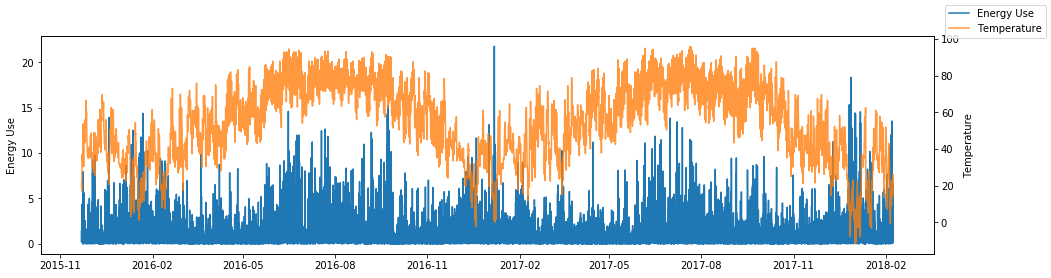

In [12]:
eemeter.plot_time_series(meter_data_hourly, temperature_data_hourly, figsize=(16, 4))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1266e8a4a8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f12655ea8d0>)

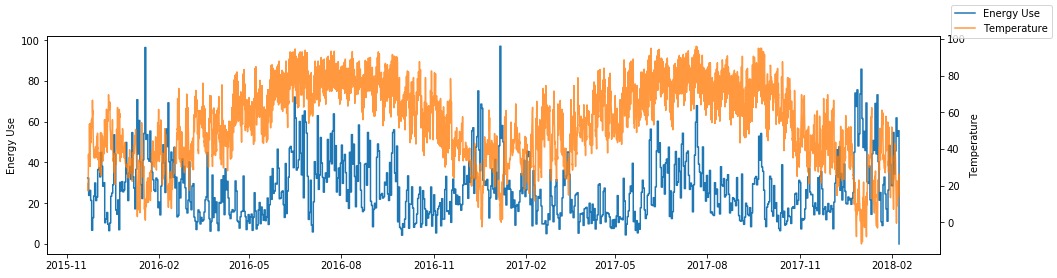

In [13]:
eemeter.plot_time_series(meter_data_daily, temperature_data_daily, figsize=(16, 4))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f12655737b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f126552a278>)

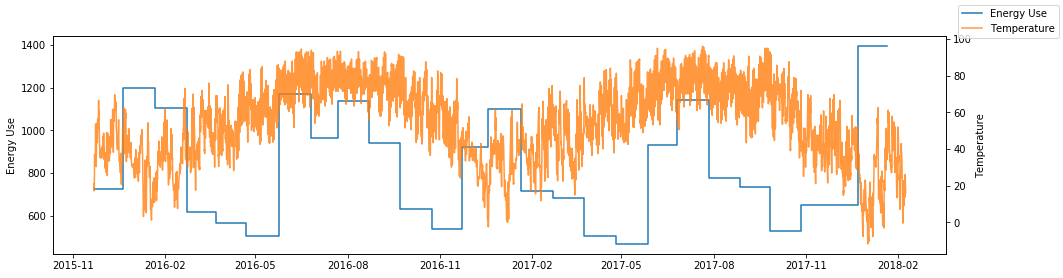

In [14]:
eemeter.plot_time_series(meter_data_billing, temperature_data_billing, figsize=(16, 4))

### Energy signature plots

The following stacks the three versions of the data - hourly, billing and daily - right on top of each other in energy signature form. This shows the temperature dependence of usage on external temperatures. These plots convert the meter data to "usage per day", which normalizes things and makes usage patterns appear roughly comparable at different sampling intervals.

- [`eemeter.plot_energy_signature`](http://eemeter.openee.io/api/html#eemeter.plot_energy_signature): Plot meter and temperature data as an energy signature.

*Remember, this data is simulated. If these correlations look too good to be true, they are!*

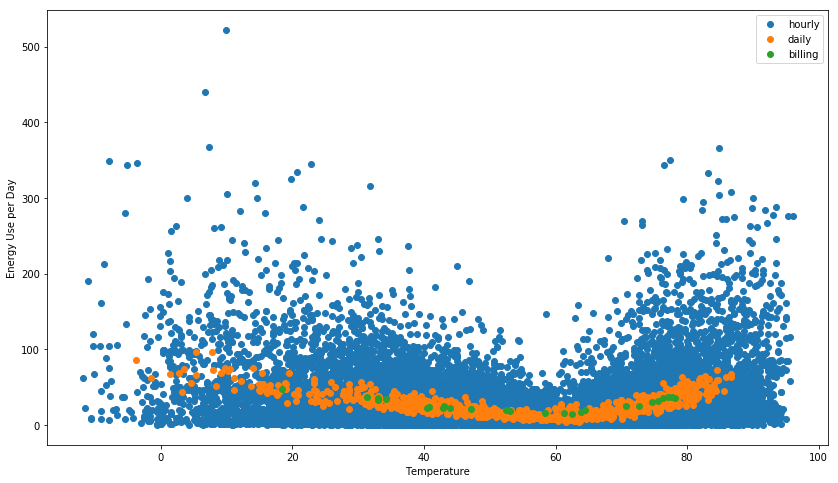

In [15]:
ax = eemeter.plot_energy_signature(meter_data_hourly, temperature_data_hourly, figsize=(14, 8))
eemeter.plot_energy_signature(meter_data_daily, temperature_data_daily, ax=ax)
eemeter.plot_energy_signature(meter_data_billing, temperature_data_billing, ax=ax)
ax.legend(labels=['hourly', 'daily', 'billing'])

## Filtering to a baseline data

The CalTRACK methods require building a model of the usage during the baseline period and then projecting that forward into the reporting period. Before we can build the baseline model we need to get isolate 365 days of meter data as immediately prior to the end of the baseline period as we can. The following function performs this filtering for us an returns a new dataset with only baseline data.

- [`eemeter.get_baseline_data`](http://eemeter.openee.io/api/html#eemeter.get_baseline_data): Filter a dataset to baseline period data.

In [16]:
baseline_meter_data_hourly, baseline_warnings_hourly = eemeter.get_baseline_data(
    meter_data_hourly, end=baseline_end_date, max_days=365)

baseline_meter_data_daily, baseline_warnings_daily = eemeter.get_baseline_data(
    meter_data_daily, end=baseline_end_date, max_days=365)

baseline_meter_data_billing, baseline_warnings_billing = eemeter.get_baseline_data(
    meter_data_billing, end=baseline_end_date, max_days=365)

To give you a sense for what this data looks like, let's tail the data again. Remember that we had a baseline end date of 2016-12-26 - so this data goes up to that data but no further, as we specified above with the `end` argument. It's also no more than 365 days long, as we specified above with the `max_days` argument. Notice that the billing data is a bit shorter because of the unevenness of billing periods. Billing periods that fall across (rather than exactly at) the boundaries are removed in this method.

In [17]:
baseline_meter_data_hourly.tail()

,value
start,
2016-12-25 20:00:00+00:00,0.14
2016-12-25 21:00:00+00:00,0.10
2016-12-25 22:00:00+00:00,0.19
2016-12-25 23:00:00+00:00,0.06
2016-12-26 00:00:00+00:00,NaN


In [18]:
baseline_meter_data_daily.tail()

,value
start,
2016-12-22 00:00:00+00:00,30.79
2016-12-23 00:00:00+00:00,28.74
2016-12-24 00:00:00+00:00,31.63
2016-12-25 00:00:00+00:00,26.45
2016-12-26 00:00:00+00:00,NaN


In [19]:
baseline_meter_data_billing.tail()

,value
start,
2016-08-22 06:00:00+00:00,942.15
2016-09-22 06:00:00+00:00,632.31
2016-10-24 06:00:00+00:00,538.24
2016-11-23 06:00:00+00:00,921.55
2016-12-19 06:00:00+00:00,NaN


If there had been any issues (e.g., unexpected gaps in the data) in filtering the data to the baseline period, some warnings would have been reported. This time we got off easy, but that will not always be the case in real-life datasets.

In [20]:
baseline_warnings_hourly, baseline_warnings_daily, baseline_warnings_billing

([], [], [])

## Creating CalTRACK Daily/Billing Method datasets

The CalTRACK daily and billing methods specifiy a way of modeling the energy signature we plotted a few cells above. We need to select a model which fits the data as well as possible. The parameters in the model are heating and cooling balance points (i.e., the temperatures at which heating/cooling related energy use tend to kick in), and the heating and cooling beta parameters, which define the slope of the energy response to incremental differences between outdoor temperature and the balance point. We'll do a grid search over possible heating and cooling balance points and fit models to the [heating and cooling degree days](https://en.wikipedia.org/wiki/Heating_degree_day)) defined by the outdoor temperatures and each of those balance points. To do this, we precompute the heating and cooling degree days using the methods below before we feed them into the modeling routines.

To make this dataset, we need to merge the meter data and temperature data into a single DataFrame. The `compute_usage_per_day_feature` function transforms the meter data into usage per day. The `compute_temperature_features` function lets us create a bunch of heating and cooling degree day values if we specify balance points to use. In this case, we'll use the wide balance point ranges recommended in the CalTRACK spec. Then we can combine the two using `merge_features`.

- [`eemeter.create_caltrack_daily_design_matrix`](http://eemeter.openee.io/api/html#eemeter.create_caltrack_daily_design_matrix): Create a design matrix for CalTRACK daily methods.
- [`eemeter.create_caltrack_billing_design_matrix`](http://eemeter.openee.io/api/html#eemeter.create_caltrack_billing_design_matrix): Create a design matrix for CalTRACK billing methods.
- [`eemeter.compute_usage_per_day_feature`](http://eemeter.openee.io/api/html#eemeter.compute_usage_per_day_feature): Transform meter data into usage per day.
- [`eemeter.compute_temperature_features`](http://eemeter.openee.io/api/html#eemeter.compute_temperature_features): Compute heating and cooling degree days and other useful temperature features.
- [`eemeter.merge_features`](http://eemeter.openee.io/api/html#eemeter.merge_features): Combine a list of Dataframe or Series objects which share an index into a single DataFrame.

In [21]:
design_matrix_daily = eemeter.create_caltrack_daily_design_matrix(
    baseline_meter_data_daily, temperature_data_daily,
)

A preview of this dataset is shown below:

In [22]:
design_matrix_daily.tail()

,meter_value,temperature_not_null,temperature_null,temperature_mean,n_days_kept,n_days_dropped,cdd_50,cdd_51,cdd_52,cdd_53,...,hdd_71,hdd_72,hdd_73,hdd_74,hdd_75,hdd_76,hdd_77,hdd_78,hdd_79,hdd_80
start,,,,,,,,,,,,,,,,,,,,,
2016-12-22 00:00:00+00:00,30.79,24.0,0.0,37.755833,1.0,0.0,0.0,0.0,0.0,0.0,...,33.244167,34.244167,35.244167,36.244167,37.244167,38.244167,39.244167,40.244167,41.244167,42.244167
2016-12-23 00:00:00+00:00,28.74,24.0,0.0,34.483333,1.0,0.0,0.0,0.0,0.0,0.0,...,36.516667,37.516667,38.516667,39.516667,40.516667,41.516667,42.516667,43.516667,44.516667,45.516667
2016-12-24 00:00:00+00:00,31.63,24.0,0.0,40.632500,1.0,0.0,0.0,0.0,0.0,0.0,...,30.367500,31.367500,32.367500,33.367500,34.367500,35.367500,36.367500,37.367500,38.367500,39.367500
2016-12-25 00:00:00+00:00,26.45,24.0,0.0,39.362500,1.0,0.0,0.0,0.0,0.0,0.0,...,31.637500,32.637500,33.637500,34.637500,35.637500,36.637500,37.637500,38.637500,39.637500,40.637500
2016-12-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
design_matrix_daily.index.min(), design_matrix_daily.index.max()

(Timestamp('2015-12-27 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2016-12-26 00:00:00+0000', tz='UTC', freq='D'))

We can do roughly the same thing for the billing data, adding a tolerance as specified in the CalTRACK methods. 

In [24]:
design_matrix_billing = eemeter.create_caltrack_billing_design_matrix(
    baseline_meter_data_billing, temperature_data_billing,
)

You'll notice that this billing data shares the structure used above for the daily data. Notice however that the magnitide of the meter value column is significantly smaller than it was before calling `compute_usage_per_day_feature` - that is because the values are returned as average usage per day, as specified by the CalTRACK methods, not as totals per period, as they are represented in the inputs. The heating/cooling degree days returned by `compute_temperature_features` are also average heating/cooling degree days per day, and not total heating/cooling degree days per period. This averaging behavior can be modified with the `use_mean_daily_values` parameter, which is set to `True` by default.

In [25]:
design_matrix_billing.tail()

,meter_value,temperature_not_null,temperature_null,temperature_mean,n_days_kept,n_days_dropped,cdd_50,cdd_51,cdd_52,cdd_53,...,hdd_71,hdd_72,hdd_73,hdd_74,hdd_75,hdd_76,hdd_77,hdd_78,hdd_79,hdd_80
start,,,,,,,,,,,,,,,,,,,,,
2016-08-22 06:00:00+00:00,30.391935,744.0,0.0,74.667392,31.0,0.0,24.667392,23.667392,22.667392,21.667392,...,0.608118,0.848831,1.170874,1.622379,2.120833,2.749825,3.422339,4.103347,4.833065,5.609059
2016-09-22 06:00:00+00:00,19.759687,768.0,0.0,64.546667,32.0,0.0,14.637852,13.681497,12.759857,11.853607,...,7.743125,8.461875,9.188073,9.962005,10.789727,11.633477,12.511029,13.455221,14.453333,15.453333
2016-10-24 06:00:00+00:00,17.941333,720.0,0.0,53.130458,30.0,0.0,5.562833,4.901917,4.268583,3.668833,...,17.931722,18.874931,19.869542,20.869542,21.869542,22.869542,23.869542,24.869542,25.869542,26.869542
2016-11-23 06:00:00+00:00,35.444231,624.0,0.0,32.976378,26.0,0.0,0.001250,0.000000,0.000000,0.000000,...,38.023622,39.023622,40.023622,41.023622,42.023622,43.023622,44.023622,45.023622,46.023622,47.023622
2016-12-19 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
design_matrix_billing.index.min(), design_matrix_billing.index.max()

(Timestamp('2016-01-22 06:00:00+0000', tz='UTC'),
 Timestamp('2016-12-19 06:00:00+0000', tz='UTC'))

If you are not running the CalTRACK hourly methods, at this point you should skip down the the section called "Running the CalTRACK Billing/Daily Methods".

## Creating CalTRACK Hourly Method datasets

The hourly methods require a multi-stage dataset creation process which is a bit more involved than the daily/billing dataset creation process above. There are two primary reasons for this extra complexity. First, unlike the daily/billing methods, the hourly methods build separate models for each calendar month, which adds a few extra steps. Second, also unlike the billing and daily methods, there are two features of the dataset creation which must themselves be fitted to a preliminary dataset -- the occupancy feature and the temperature bin features.

### Creating a preliminary dataset

The preliminary dataset has some simple time and temperature features. These features do not vary by segment and are precursors to other features (See below for a better explanation of segmentation). This step looks a lot like the daily/billing dataset creation. These features are used subsequently to fit the occupancy and temperature bin features.

- [`eemeter.create_caltrack_hourly_preliminary_design_matrix`](http://eemeter.openee.io/api/html#eemeter.create_caltrack_hourly_preliminary_design_matrix): Create a design matrix for the first stage of CalTRACK hourly.
- [`eemeter.compute_time_features`](http://eemeter.openee.io/api/html#eemeter.compute_time_features): Create a time feature for the index (`time_of_week`).
- [`eemeter.compute_temperature_features`](http://eemeter.openee.io/api/html#eemeter.compute_temperature_features): Compute heating and cooling degree days and other useful temperature features.
- [`eemeter.merge_features`](http://eemeter.openee.io/api/html#eemeter.merge_features): Combine a list of Dataframe or Series objects which share an index into a single DataFrame.


In [27]:
preliminary_design_matrix_hourly = eemeter.create_caltrack_hourly_preliminary_design_matrix(
    baseline_meter_data_hourly, temperature_data_hourly,
)

Let's take a peek at this data. This time, we have only two fixed heating and cooling degree day columns - these are used to fit the occupancy model. But we also have an hour of week column, which is a categorical variable indicating the hour of the week using an integer from 1 to 168 (i.e., `7*24`).

In [28]:
preliminary_design_matrix_hourly.tail()

,meter_value,temperature_mean,cdd_65,hdd_50,n_hours_dropped,n_hours_kept,hour_of_week
start,,,,,,,
2016-12-25 20:00:00+00:00,0.14,42.30,0.0,7.70,0.0,1.0,164.0
2016-12-25 21:00:00+00:00,0.10,42.99,0.0,7.01,0.0,1.0,165.0
2016-12-25 22:00:00+00:00,0.19,43.65,0.0,6.35,0.0,1.0,166.0
2016-12-25 23:00:00+00:00,0.06,44.64,0.0,5.36,0.0,1.0,167.0
2016-12-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Segmentation

To handle creating multiple independent models on a shared dataset (as is required for CalTRACK hourly), we have introduced a concept which we are calling segmentation. Segmentation breaks a dataset into $n$ named and weighted subsets.

Before we can move on to the next steps of creating the CalTRACK hourly dataset, we need to create a segmentation for the hourly data. We will use this to create 12 independent hourly models - one for each month of the calendar year. The eemeter function for creating these weights is called `segment_time_series` and it takes a `DatetimeIndex` as input.

This segmentation matrix contains 1 column for each segment (12 in all), each of which contains the segmentation weights for that column. The segmentation scheme we use here is to have one segment for each month which contains a single fully weighted calendar month and two half-weighted neighboring calendar months. The eemeter code name for this segmentation scheme is called `'three_month_weighted'` (There's also `all`, `one_month`, and `three_month`, each of which behaves a bit differently).

We are creating this segmentation over the time index of the baseline period that is represented in the preliminary hourly design matrix.

- [`eemeter.segment_time_series`](http://eemeter.openee.io/api/html#eemeter.segment_time_series): Create a segmentation using the specified scheme.

In [29]:
segmentation_hourly = eemeter.segment_time_series(
    preliminary_design_matrix_hourly.index,
    'three_month_weighted'
)
segmentation_hourly.head()

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
start,,,,,,,,,,,,
2015-12-27 00:00:00+00:00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0
2015-12-27 01:00:00+00:00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0
2015-12-27 02:00:00+00:00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0
2015-12-27 03:00:00+00:00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0
2015-12-27 04:00:00+00:00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0


These segments are probably a bit easier to understand when plotted visually. The areas in the following chart represent the weights assigned to the data at particular hours. A weight of 1 is full weight, as weight of 0 indicates that the data is ignored for that segment. These segments look like 3-month long tetris blocks and indicate half-weight/full-weight/half-weight for the three months they cover. For instance, the `dec-jan-feb-weighted` segment (which will eventually be used to estimate usage for january) includes a fully weighted january but also half-weighted december and february. These weights wrap around the calendar year, so both January and December of 2017 might end up in the same dataset.

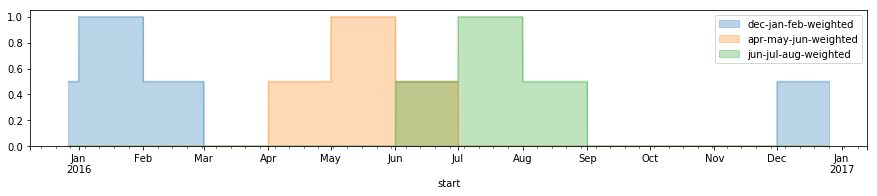

In [30]:
# example segmentation weights
segmentation_hourly[[
    'dec-jan-feb-weighted',
    'apr-may-jun-weighted',
    'jun-jul-aug-weighted'
]].plot.area(stacked=False, alpha=0.3, figsize=(15, 2.5))

### Fitting segmented occupancy lookups

Occupancy is estimated by building a simple model from the preliminary design matrix hdd_50 and cdd_65 columns. This is done for each segment independently, so results are returned as a dataframe with one segment of results per column. The `segmentation` argument indicates that the analysis should be done once per segment. Occupancy is determined by hour of week category. A value of 1 for a particular hour indicates an "occupied" mode, and a value of 0 indicates "unoccupied" mode. These modes are determined by the tendency of the hdd_50/cdd_65 model to over- or under-predict usage for that hour, given a particular threshold between 0 and 1 (if the percent of underpredictions (by count) is lower than that threshold, then the mode is "unoccupied", otherwise the mode is "occupied").

- [`eemeter.estimate_hour_of_week_occupancy`](http://eemeter.openee.io/api/html#eemeter.estimate_hour_of_week_occupancy): Estimate occupancy by time of week for each segment.

In [31]:
occupancy_lookup_hourly = eemeter.estimate_hour_of_week_occupancy(
    preliminary_design_matrix_hourly,
    segmentation=segmentation_hourly,
    # threshold=0.65  # default
)

The occupancy lookup is organized by hour of week (rows) and model segment (columns).

In [32]:
occupancy_lookup_hourly.head()

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
hour_of_week,,,,,,,,,,,,
0,0,0,0,0,0,0,0,1,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,0,0
4,0,0,0,1,1,1,0,0,0,0,0,0


### Fitting segmented temperature bins

Temperature bins are fit for each segment such that each bin has sufficient number of temperature readings.  Bins are defined by starting with a proposed set of bins (see the `default_bins` argument) and systematically dropping bin endpoints. Bins themselves are not dropped but are effectively combined with neighboring bins. Except for the fact that zero-weighted times are dropped, segment weights are not considered when fitting temperature bins.

- [`eemeter.fit_temperature_bins`](http://eemeter.openee.io/api/html#eemeter.fit_temperature_bins): Fit temperature bins to data, dropping bin endpoints for bins that do not meet the minimum temperature count such that remaining bins meet the minimum count.

In [33]:
temperature_bins_hourly = eemeter.fit_temperature_bins(
    preliminary_design_matrix_hourly,
    segmentation=segmentation_hourly,
    # default_bins=[30, 45, 55, 65, 75, 90],  # default
    # min_temperature_count=20  # default
)

Because bin fitting and validation is done independently for each segment, results are returned as a dataframe with one segment of results per column. The contents of the dataframe are boolean indicators of whether the bin endpoint should be used for temperatures in that segment. Some bin endpoints are dropped because of insufficient reading counts. The bin endpoints that are dropped for each segment are given a value of `False`. You'll notice in this dataset that the the winter months tend to have combined high temperature bins and the summer months tend to have combined low temperature bins.

In [34]:
temperature_bins_hourly

,dec-jan-feb-weighted,jan-feb-mar-weighted,feb-mar-apr-weighted,mar-apr-may-weighted,apr-may-jun-weighted,may-jun-jul-weighted,jun-jul-aug-weighted,jul-aug-sep-weighted,aug-sep-oct-weighted,sep-oct-nov-weighted,oct-nov-dec-weighted,nov-dec-jan-weighted
bin_endpoints,,,,,,,,,,,,
30,True,True,True,True,False,False,False,False,False,True,True,True
45,True,True,True,True,True,False,False,False,True,True,True,True
55,True,True,True,True,True,True,False,False,True,True,True,True
65,False,True,True,True,True,True,True,True,True,True,True,True
75,False,False,True,True,True,True,True,True,True,True,True,False
90,False,False,False,False,True,True,True,True,True,False,False,False


With these in hand, now we can combine them into a segmented dataset using the helper function `iterate_segmented_dataset` and a prefabricated feature processor `caltrack_hourly_fit_feature_processor` which is provided to assist creating the segmented dataset given a preliminary design matrix of the form created above. The feature processor transforms the each segment of the dataset using the occupancy lookup and temperature bins created above. We are creating a python `dict` of pandas `Dataframes` - one for each time series segment encountered in the baseline data. 

In [35]:
segmented_design_matrices_hourly = eemeter.create_caltrack_hourly_segmented_design_matrices(
    preliminary_design_matrix_hourly,
    segmentation_hourly,
    occupancy_lookup_hourly,
    temperature_bins_hourly,
)

The keys of the dict are segment names. The values are DataFrame objects containing the exact data needed to fit the a CalTRACK hourly model.

In [36]:
print(segmented_design_matrices_hourly.keys())
segmented_design_matrices_hourly['dec-jan-feb-weighted'].head()

dict_keys(['dec-jan-feb-weighted', 'jan-feb-mar-weighted', 'feb-mar-apr-weighted', 'mar-apr-may-weighted', 'apr-may-jun-weighted', 'may-jun-jul-weighted', 'jun-jul-aug-weighted', 'jul-aug-sep-weighted', 'aug-sep-oct-weighted', 'sep-oct-nov-weighted', 'oct-nov-dec-weighted', 'nov-dec-jan-weighted'])


,meter_value,hour_of_week,occupancy,bin_0,bin_1,bin_2,bin_3,weight
start,,,,,,,,
2015-12-27 00:00:00+00:00,0.46,144,0.0,30.0,15.0,4.98,0.0,0.5
2015-12-27 01:00:00+00:00,0.95,145,0.0,30.0,15.0,3.77,0.0,0.5
2015-12-27 02:00:00+00:00,0.73,146,0.0,30.0,15.0,2.33,0.0,0.5
2015-12-27 03:00:00+00:00,0.23,147,0.0,30.0,15.0,1.07,0.0,0.5
2015-12-27 04:00:00+00:00,2.52,148,0.0,30.0,15.0,0.33,0.0,0.5


## Running the CalTRACK Billing/Daily Methods

The following use the design matrix datasets that we created in the previous steps and uses them with the CalTRACK method. This gives us a baseline model, which is the key predictive component of the metered savings calculation.

In [37]:
baseline_model_results_daily = eemeter.fit_caltrack_usage_per_day_model(
    design_matrix_daily,
)

In [38]:
baseline_model_results_billing = eemeter.fit_caltrack_usage_per_day_model(
    design_matrix_billing,
    use_billing_presets=True,
    weights_col='n_days_kept',
)

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Running the CalTRACK Hourly Methods

In [39]:
baseline_segmented_model_hourly = eemeter.fit_caltrack_hourly_model(
    segmented_design_matrices_hourly,
    occupancy_lookup_hourly,
    temperature_bins_hourly,
)

## Plotting (part 2)

### Daily and billing method plots

To see what this model fit looks like, we can plot the result against the energy signature.

/app/eemeter/features.py:197: RuntimeWarning: invalid value encountered in maximum
  for bp in cooling_balance_points
/app/eemeter/features.py:203: RuntimeWarning: invalid value encountered in maximum
  for bp in heating_balance_points


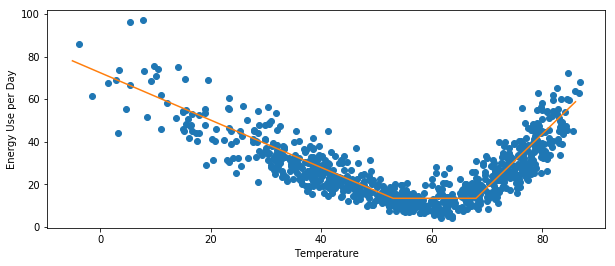

In [40]:
ax = eemeter.plot_energy_signature(meter_data_daily, temperature_data_daily)
baseline_model_results_daily.plot(ax=ax, temp_range=(-5, 88))

/app/eemeter/features.py:197: RuntimeWarning: invalid value encountered in maximum
  for bp in cooling_balance_points
/app/eemeter/features.py:203: RuntimeWarning: invalid value encountered in maximum
  for bp in heating_balance_points


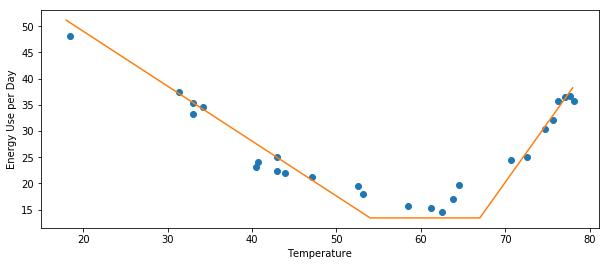

In [41]:
ax = eemeter.plot_energy_signature(meter_data_billing, temperature_data_billing)
baseline_model_results_billing.plot(ax=ax, temp_range=(18, 80))

We can also compare the two models and see that there is a slight, but not drastic, difference between them.

/app/eemeter/features.py:197: RuntimeWarning: invalid value encountered in maximum
  for bp in cooling_balance_points
/app/eemeter/features.py:203: RuntimeWarning: invalid value encountered in maximum
  for bp in heating_balance_points


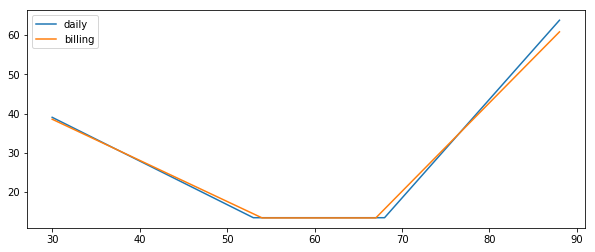

In [42]:
ax = baseline_model_results_daily.model.plot(color='C0', best=True, label='daily')
ax = baseline_model_results_billing.model.plot(ax=ax, color='C1', best=True, label='billing')
ax.legend()

## Reporting period metered savings

The moment of truth. Calculating CalTRACK metered savings.

First, we need a reporting period. The following gets the reporting period date.

In [43]:
reporting_start_date = metadata_billing['blackout_start_date']

Now we get the first year of data for that period.

In [44]:
reporting_meter_data_hourly, warnings = eemeter.get_reporting_data(
    meter_data_hourly, start=reporting_start_date, max_days=365)

reporting_meter_data_daily, warnings = eemeter.get_reporting_data(
    meter_data_daily, start=reporting_start_date, max_days=365)

reporting_meter_data_billing, warnings = eemeter.get_reporting_data(
    meter_data_billing, start=reporting_start_date, max_days=365)

The `eemeter.metered_savings` method performs the logic of estimating counterfactual baseline reporting period usage. For this, it requires the fitted baseline model, the reporting period meter data (for its index - so that it can be properly joined later), and corresponding temperature data. Note that this method can return results disaggregated into base load, cooling load, or heating load or as the aggregated usage. We do both here for demonstration purposes.

In [45]:
metered_savings_hourly, error_bands = eemeter.metered_savings(
    baseline_segmented_model_hourly, reporting_meter_data_hourly,
    temperature_data_hourly
)

metered_savings_daily, error_bands = eemeter.metered_savings(
    baseline_model_results_daily, reporting_meter_data_daily,
    temperature_data_daily, with_disaggregated=True
)

metered_savings_billing, error_bands = eemeter.metered_savings(
    baseline_model_results_billing, reporting_meter_data_billing,
    temperature_data_billing, with_disaggregated=True
)

In [46]:
metered_savings_hourly.head()

,reporting_observed,counterfactual_usage,metered_savings
start,,,
2016-12-26 00:00:00+00:00,0.71,2.085000,1.375000
2016-12-26 01:00:00+00:00,0.54,1.085000,0.545000
2016-12-26 02:00:00+00:00,1.12,0.885625,-0.234375
2016-12-26 03:00:00+00:00,0.66,1.248750,0.588750
2016-12-26 04:00:00+00:00,1.01,1.498125,0.488125


In [47]:
metered_savings_daily.head()

,reporting_observed,counterfactual_usage,metered_savings,counterfactual_base_load,counterfactual_heating_load,counterfactual_cooling_load
start,,,,,,
2016-12-26 00:00:00+00:00,12.75,13.472386,0.722386,13.472386,0.000000,0.0
2016-12-27 00:00:00+00:00,22.68,32.476405,9.796405,13.472386,19.004020,0.0
2016-12-28 00:00:00+00:00,28.52,32.419400,3.899400,13.472386,18.947015,0.0
2016-12-29 00:00:00+00:00,36.85,29.588147,-7.261853,13.472386,16.115761,0.0
2016-12-30 00:00:00+00:00,26.87,33.227204,6.357204,13.472386,19.754819,0.0


In [48]:
metered_savings_billing.head()

,reporting_observed,counterfactual_usage,metered_savings,counterfactual_base_load,counterfactual_heating_load,counterfactual_cooling_load
start,,,,,,
2017-01-21 06:00:00+00:00,717.58,871.909019,154.329019,416.022903,455.886117,0.000000
2017-02-21 06:00:00+00:00,682.58,767.491490,84.911490,416.022903,351.468587,0.000000
2017-03-24 06:00:00+00:00,503.42,521.984343,18.564343,429.442996,46.631350,45.909996
2017-04-25 06:00:00+00:00,467.65,597.360739,129.710739,429.442996,22.066013,145.851730
2017-05-27 06:00:00+00:00,929.39,955.441124,26.051124,389.182715,0.000000,566.258409


In [49]:
columns = ["reporting_observed", "counterfactual_usage", "metered_savings"]

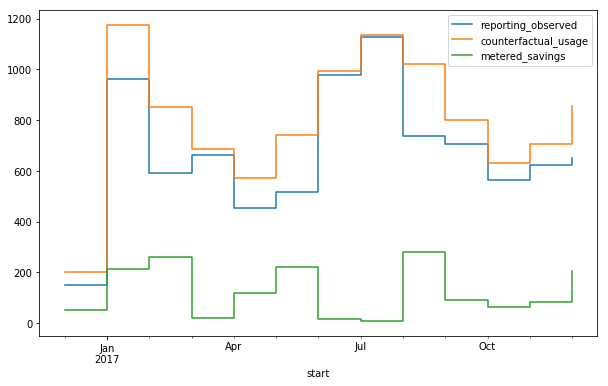

In [50]:
metered_savings_hourly[columns].resample('MS').sum().plot(figsize=(10, 6), drawstyle="steps-post")

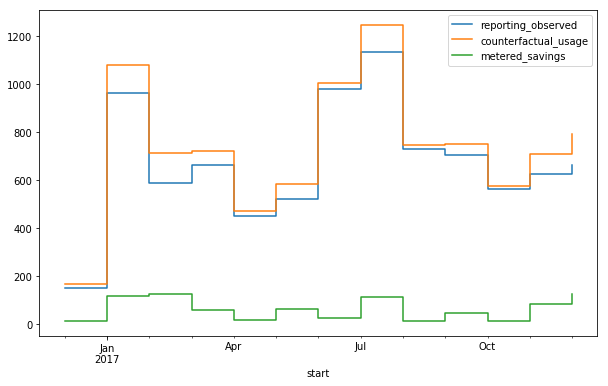

In [51]:
metered_savings_daily[columns].resample('MS').sum().plot(figsize=(10, 6), drawstyle="steps-post")

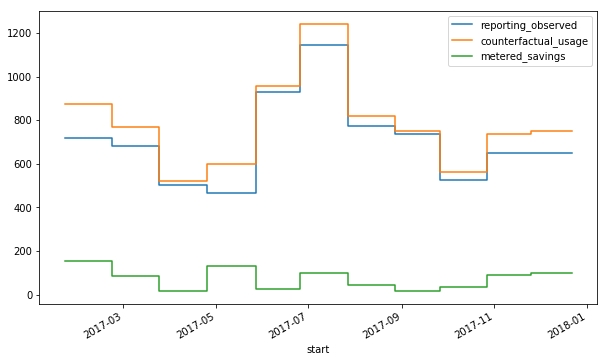

In [52]:
metered_savings_billing[columns].plot(figsize=(10, 6), drawstyle="steps-post")

These can be easily aggregated

In [53]:
total_savings_hourly = metered_savings_hourly.metered_savings.sum()
percent_savings_hourly = total_savings_hourly / metered_savings_hourly.counterfactual_usage.sum() * 100
print('Hourly: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_hourly, percent_savings_hourly))

total_savings_daily = metered_savings_daily.metered_savings.sum()
percent_savings_daily = total_savings_daily / metered_savings_daily.counterfactual_usage.sum() * 100
print('Daily: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_daily, percent_savings_daily))

total_savings_billing = metered_savings_billing.metered_savings.sum()
percent_savings_billing = total_savings_billing / metered_savings_billing.counterfactual_usage.sum() * 100
print('Billing: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_billing, percent_savings_billing))

Hourly: Saved 1631.9 kWh in first year (15.7%)
Daily: Saved 814.5 kWh in first year (8.5%)
Billing: Saved 795.7 kWh in first year (9.3%)


**NOTE**: These results differ somewhat due to the different lengths of the reporting periods - the billing version of the reporting period was a bit shorter because the billing periods over which we computed savings didn't exactly align with 365 day period we requested, as they did for the daily reporting period data.

## Annual weather-normalized modeled savings

If we want to compute annual weather normalized modeled savings, we'll need a reporting period model. The following code repeats what we did for the baseline period with the reporting period.

In [54]:
reporting_preliminary_design_matrix_hourly = eemeter.create_caltrack_hourly_preliminary_design_matrix(
    reporting_meter_data_hourly, temperature_data_hourly,
)
reporting_segmentation_hourly = eemeter.segment_time_series(
    reporting_preliminary_design_matrix_hourly.index,
    'three_month_weighted'
)
reporting_occupancy_lookup_hourly = eemeter.estimate_hour_of_week_occupancy(
    reporting_preliminary_design_matrix_hourly,
    segmentation=reporting_segmentation_hourly,
)
reporting_temperature_bins_hourly = eemeter.fit_temperature_bins(
    reporting_preliminary_design_matrix_hourly,
    segmentation=reporting_segmentation_hourly,
)
reporting_segmentation_design_matrices_hourly = eemeter.create_caltrack_hourly_segmented_design_matrices(
    reporting_preliminary_design_matrix_hourly,
    reporting_segmentation_hourly,
    reporting_occupancy_lookup_hourly,
    reporting_temperature_bins_hourly
)

In [55]:
reporting_design_matrix_daily = eemeter.create_caltrack_daily_design_matrix(
    reporting_meter_data_daily, temperature_data_daily,
)

In [56]:
reporting_design_matrix_billing = eemeter.create_caltrack_billing_design_matrix(
    reporting_meter_data_billing, temperature_data_billing,
)

In [57]:
reporting_segmented_model_hourly = eemeter.fit_caltrack_hourly_model(
    reporting_segmentation_design_matrices_hourly,
    reporting_occupancy_lookup_hourly,
    reporting_temperature_bins_hourly
)

In [58]:
reporting_model_results_daily = eemeter.fit_caltrack_usage_per_day_model(
    reporting_design_matrix_daily,
)

In [59]:
reporting_model_results_billing = eemeter.fit_caltrack_usage_per_day_model(
    reporting_design_matrix_billing,
    use_billing_presets=True,
    weights_col='n_days_kept',
)

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


/app/eemeter/features.py:197: RuntimeWarning: invalid value encountered in maximum
  for bp in cooling_balance_points
/app/eemeter/features.py:203: RuntimeWarning: invalid value encountered in maximum
  for bp in heating_balance_points


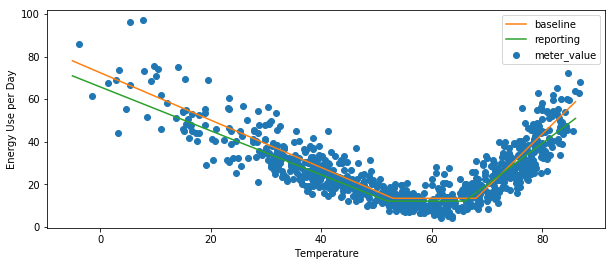

In [60]:
ax = eemeter.plot_energy_signature(meter_data_daily, temperature_data_daily)
ax = baseline_model_results_daily.model.plot(ax=ax, color='C1', best=True, label='baseline', temp_range=(-5, 88))
ax = reporting_model_results_daily.model.plot(ax=ax, color='C2', best=True, label='reporting', temp_range=(-5, 88))
ax.legend()

/app/eemeter/features.py:197: RuntimeWarning: invalid value encountered in maximum
  for bp in cooling_balance_points
/app/eemeter/features.py:203: RuntimeWarning: invalid value encountered in maximum
  for bp in heating_balance_points


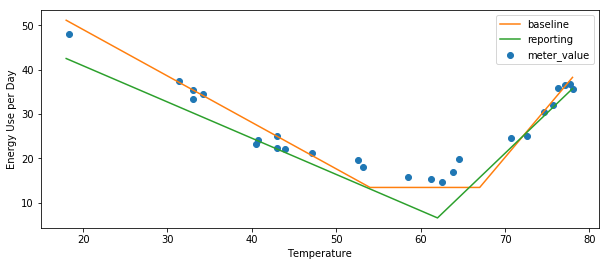

In [61]:
ax = eemeter.plot_energy_signature(meter_data_billing, temperature_data_billing)
ax = baseline_model_results_billing.model.plot(ax=ax, color='C1', best=True, label='baseline', temp_range=(18, 80))
ax = reporting_model_results_billing.model.plot(ax=ax, color='C2', best=True, label='reporting', temp_range=(18, 80))
ax.legend()

The last thing we need to do before obtaining annualized and weather-normalized results is to obtain normal year temperature data. For simplicity, let's just call 2017 our "normal year". To be completely clear, this is not something you would do in practice, but this demonstrates the functionality. To use real temperature normals, check out the [EEWeather](http://eeweather.openee.io/) package.

In [62]:
import pandas as pd
normal_year_temperatures = temperature_data_daily[temperature_data_daily.index.year == 2017]
result_index = pd.date_range('2017-01-01', periods=365, freq='D', tz='UTC')

Now we are ready to obtain our annualized savings.

In [63]:
annualized_savings_hourly = eemeter.modeled_savings(
    baseline_segmented_model_hourly, reporting_segmented_model_hourly,
    result_index, normal_year_temperatures, with_disaggregated=True
)

annualized_savings_daily = eemeter.modeled_savings(
    baseline_model_results_daily, reporting_model_results_daily,
    result_index, normal_year_temperatures, with_disaggregated=True
)

annualized_savings_billing = eemeter.modeled_savings(
    baseline_model_results_billing, reporting_model_results_billing,
    result_index, normal_year_temperatures, with_disaggregated=True
)

In [64]:
annualized_savings_hourly.head()

,modeled_baseline_usage,modeled_reporting_usage,modeled_savings
2017-01-01 00:00:00+00:00,1.046842,0.743889,0.302953
2017-01-02 00:00:00+00:00,1.245294,0.883158,0.362136
2017-01-03 00:00:00+00:00,1.600625,0.604444,0.996181
2017-01-04 00:00:00+00:00,2.429375,1.270625,1.158750
2017-01-05 00:00:00+00:00,0.773529,0.735000,0.038529


In [65]:
annualized_savings_daily.head()

,modeled_baseline_usage,modeled_reporting_usage,modeled_savings,modeled_baseline_base_load,modeled_baseline_heating_load,modeled_baseline_cooling_load,modeled_reporting_base_load,modeled_reporting_heating_load,modeled_reporting_cooling_load,modeled_base_load_savings,modeled_heating_load_savings,modeled_cooling_load_savings
2017-01-01 00:00:00+00:00,39.323043,35.088762,4.234281,13.472386,25.850658,0.0,12.155685,22.933077,0.0,1.316701,2.917580,0.0
2017-01-02 00:00:00+00:00,28.253393,24.826921,3.426472,13.472386,14.781007,0.0,12.155685,12.671236,0.0,1.316701,2.109771,0.0
2017-01-03 00:00:00+00:00,26.005167,22.742760,3.262407,13.472386,12.532781,0.0,12.155685,10.587075,0.0,1.316701,1.945706,0.0
2017-01-04 00:00:00+00:00,49.620112,44.634401,4.985711,13.472386,36.147727,0.0,12.155685,32.478716,0.0,1.316701,3.669011,0.0
2017-01-05 00:00:00+00:00,55.221907,49.827404,5.394503,13.472386,41.749521,0.0,12.155685,37.671719,0.0,1.316701,4.077802,0.0


In [66]:
annualized_savings_billing.head()

,modeled_baseline_usage,modeled_reporting_usage,modeled_savings,modeled_baseline_base_load,modeled_baseline_heating_load,modeled_baseline_cooling_load,modeled_reporting_base_load,modeled_reporting_heating_load,modeled_reporting_cooling_load,modeled_base_load_savings,modeled_heating_load_savings,modeled_cooling_load_savings
2017-01-01 00:00:00+00:00,38.822906,32.898922,5.923984,13.420094,25.402812,0.0,6.544231,26.354691,0.0,6.875863,-0.951879,0.0
2017-01-02 00:00:00+00:00,28.393771,24.763770,3.630002,13.420094,14.973678,0.0,6.544231,18.219539,0.0,6.875863,-3.245861,0.0
2017-01-03 00:00:00+00:00,26.275633,23.111535,3.164098,13.420094,12.855540,0.0,6.544231,16.567304,0.0,6.875863,-3.711765,0.0
2017-01-04 00:00:00+00:00,48.524162,40.466299,8.057862,13.420094,35.104068,0.0,6.544231,33.922069,0.0,6.875863,1.182000,0.0
2017-01-05 00:00:00+00:00,53.801823,44.583092,9.218732,13.420094,40.381729,0.0,6.544231,38.038861,0.0,6.875863,2.342869,0.0


The following plot demonstrates that in this case, the billing model represents most of the modeled savings as base load savings. This reflects the behavior seen in the model comparison above.

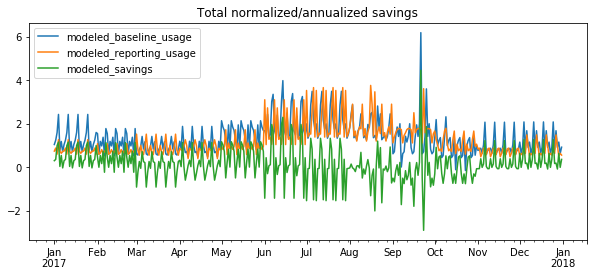

In [67]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 4))

annualized_savings_hourly[[
    'modeled_baseline_usage',
    'modeled_reporting_usage',
    'modeled_savings',
]].plot(ax=axes)
axes.set_title('Total normalized/annualized savings')
plt.show()

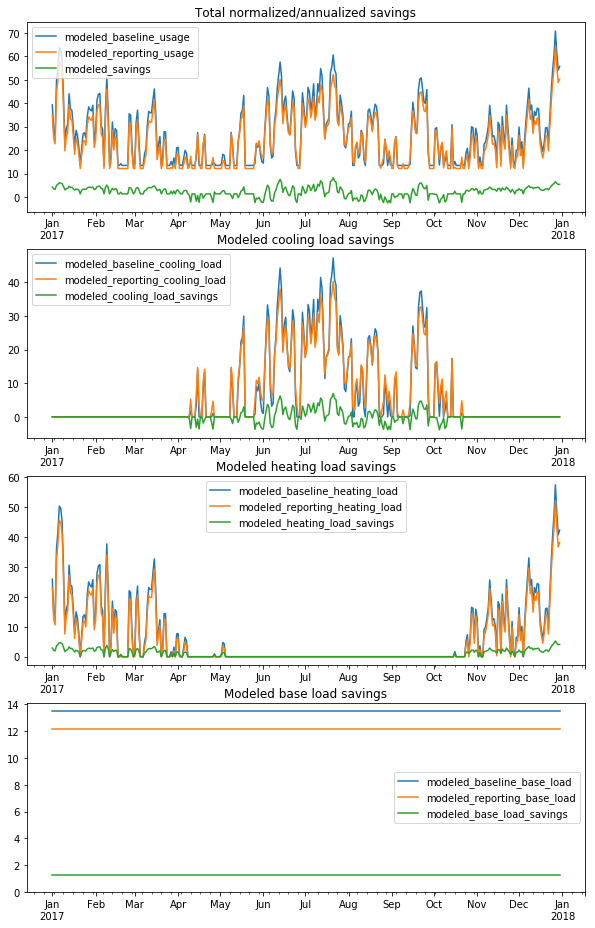

In [68]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 1, figsize=(10, 16))

annualized_savings_daily[[
    'modeled_baseline_usage',
    'modeled_reporting_usage',
    'modeled_savings',
]].plot(ax=axes[0])
axes[0].set_title('Total normalized/annualized savings')

annualized_savings_daily[[
    'modeled_baseline_cooling_load',
    'modeled_reporting_cooling_load',
    'modeled_cooling_load_savings',
]].plot(ax=axes[1])
axes[1].set_title('Modeled cooling load savings')

annualized_savings_daily[[
    'modeled_baseline_heating_load',
    'modeled_reporting_heating_load',
    'modeled_heating_load_savings',
]].plot(ax=axes[2])
axes[2].set_title('Modeled heating load savings')

ax = annualized_savings_daily[[
    'modeled_baseline_base_load',
    'modeled_reporting_base_load',
    'modeled_base_load_savings',
]].plot(ax=axes[3])
axes[3].set_title('Modeled base load savings')
lim = axes[3].set_ylim((0, None))

plt.show()

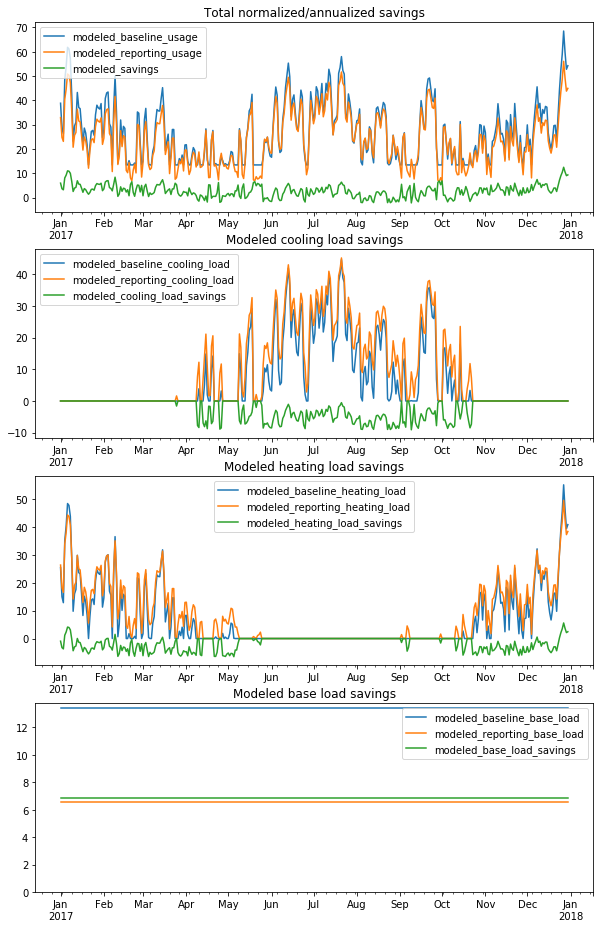

In [69]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 1, figsize=(10, 16))

annualized_savings_billing[[
    'modeled_baseline_usage',
    'modeled_reporting_usage',
    'modeled_savings',
]].plot(ax=axes[0])
axes[0].set_title('Total normalized/annualized savings')

annualized_savings_billing[[
    'modeled_baseline_cooling_load',
    'modeled_reporting_cooling_load',
    'modeled_cooling_load_savings',
]].plot(ax=axes[1])
axes[1].set_title('Modeled cooling load savings')

annualized_savings_billing[[
    'modeled_baseline_heating_load',
    'modeled_reporting_heating_load',
    'modeled_heating_load_savings',
]].plot(ax=axes[2])
axes[2].set_title('Modeled heating load savings')

ax = annualized_savings_billing[[
    'modeled_baseline_base_load',
    'modeled_reporting_base_load',
    'modeled_base_load_savings',
]].plot(ax=axes[3])
axes[3].set_title('Modeled base load savings')
lim = axes[3].set_ylim((0, None))

plt.show()

In this case, as totals, the annualized savings look pretty similar to the metered savings.

In [70]:
total_savings_hourly = annualized_savings_hourly.modeled_savings.sum()
percent_savings_hourly = total_savings_hourly / annualized_savings_hourly.modeled_baseline_usage.sum() * 100
print('Hourly: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_hourly, percent_savings_hourly))

total_savings_daily = annualized_savings_daily.modeled_savings.sum()
percent_savings_daily = total_savings_daily / annualized_savings_daily.modeled_baseline_usage.sum() * 100
print('Daily: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_daily, percent_savings_daily))

total_savings_billing = annualized_savings_billing.modeled_savings.sum()
percent_savings_billing = total_savings_billing / annualized_savings_billing.modeled_baseline_usage.sum() * 100
print('Billing: Saved {:.1f} kWh in first year ({:.1f}%)'.format(total_savings_billing, percent_savings_billing))

Hourly: Saved 56.7 kWh in first year (11.3%)
Daily: Saved 824.1 kWh in first year (8.5%)
Billing: Saved 983.5 kWh in first year (10.1%)


If we're interested in seeing more about models the CalTRACK method tried, we can even plot all the model candidates as well. There are a ton of these, so the reduced alpha makes it a bit easier to see what's going on. Each faint line represents a model that was tried and bested by the (orange) selected model, which had the highest r-squared. Candidates appear green if `QUALIFIED` and red if `DISQUALIFIED`.  A model might be disqualified if it had unphysical (i.e., negative) coefficients.

/app/eemeter/features.py:203: RuntimeWarning: invalid value encountered in maximum
  for bp in heating_balance_points
/app/eemeter/features.py:197: RuntimeWarning: invalid value encountered in maximum
  for bp in cooling_balance_points


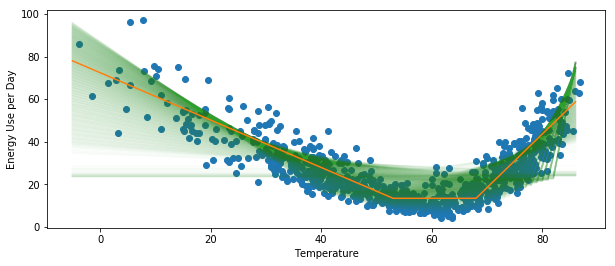

In [71]:
ax = eemeter.plot_energy_signature(meter_data_daily, temperature_data_daily)
baseline_model_results_daily.plot(
    ax=ax,
    candidate_alpha=0.02,
    with_candidates=True,
    temp_range=(-5, 88)
)

/app/eemeter/features.py:203: RuntimeWarning: invalid value encountered in maximum
  for bp in heating_balance_points
/app/eemeter/features.py:197: RuntimeWarning: invalid value encountered in maximum
  for bp in cooling_balance_points


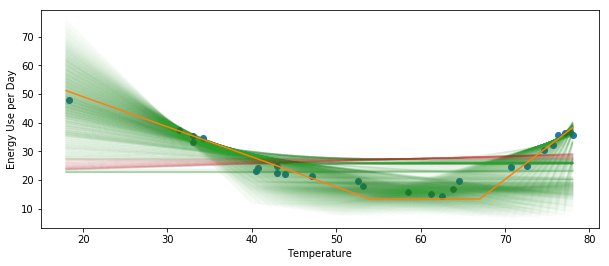

In [72]:
ax = eemeter.plot_energy_signature(meter_data_billing, temperature_data_billing)
baseline_model_results_billing.plot(
    ax=ax,
    candidate_alpha=0.02,
    with_candidates=True,
    temp_range=(18, 80)
)

## CalTRACK Hourly plots


Coming soon.

## Inspecting CalTRACKUsagePerDayModelResults objects: status, candidates, warnings, json


In addition to being plottable, the model_fit object is an instance of the class [eemeter.ModelFit](http://eemeter.openee.io/api.html#eemeter.ModelFit) and contains a bunch of interesting information about this modeling process. 

For instance, there's a status. This status is one of the following:

- `'SUCCESS'`: qualified model selected.
- `'NO MODEL'`: no candidate models qualified.
- `'NO DATA'`: no data was given.

In [73]:
baseline_model_results_billing.status, baseline_model_results_daily.status

('SUCCESS', 'SUCCESS')

There is also a "best" candidate model:

In [74]:
baseline_model_results_billing.model, baseline_model_results_daily.model

(CalTRACKUsagePerDayCandidateModel(model_type='cdd_hdd', formula='meter_value ~ cdd_67 + hdd_54', status='QUALIFIED', r_squared_adj=0.994),
 CalTRACKUsagePerDayCandidateModel(model_type='cdd_hdd', formula='meter_value ~ cdd_68 + hdd_53', status='QUALIFIED', r_squared_adj=0.768))

And a list of all candidate models that were tried, many of which have (much) lower r-squared than the best model.

In [75]:
baseline_model_results_billing.candidates[:5]  # (there are a lot, so only showing the first 5)

[CalTRACKUsagePerDayCandidateModel(model_type='intercept_only', formula='meter_value ~ 1', status='QUALIFIED', r_squared_adj=0),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_40', status='QUALIFIED', r_squared_adj=0.051),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_41', status='QUALIFIED', r_squared_adj=0.047),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_42', status='QUALIFIED', r_squared_adj=0.041),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_43', status='QUALIFIED', r_squared_adj=0.035)]

In [76]:
baseline_model_results_daily.candidates[:5] 

[CalTRACKUsagePerDayCandidateModel(model_type='intercept_only', formula='meter_value ~ 1', status='QUALIFIED', r_squared_adj=0),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_40', status='QUALIFIED', r_squared_adj=0.273),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_41', status='QUALIFIED', r_squared_adj=0.274),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_42', status='QUALIFIED', r_squared_adj=0.274),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_43', status='QUALIFIED', r_squared_adj=0.273)]

Any associated warnings on both the model_fit object and the best candidate model object:

In [77]:
baseline_model_results_billing.warnings, baseline_model_results_billing.warnings

([], [])

In [78]:
baseline_model_results_daily.warnings, baseline_model_results_daily.warnings

([], [])

The best models don't appear to have any issues but the billing model did (see the faint red lines in the chart above).

In [79]:
disqualified_candidates = [
    candidate
    for candidate in baseline_model_results_billing.candidates
    if candidate.status == 'DISQUALIFIED'
]  # this is a python list comprehension
disqualified_candidates[:10]

[CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_67', status='DISQUALIFIED', r_squared_adj=-0.111),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_68', status='DISQUALIFIED', r_squared_adj=-0.111),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_69', status='DISQUALIFIED', r_squared_adj=-0.109),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_70', status='DISQUALIFIED', r_squared_adj=-0.108),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_71', status='DISQUALIFIED', r_squared_adj=-0.105),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_72', status='DISQUALIFIED', r_squared_adj=-0.102),
 CalTRACKUsagePerDayCandidateModel(model_type='hdd_only', formula='meter_value ~ hdd_73', status='DISQUALIFIED', r_squared_adj=-0.099),
 CalTRACKUsagePerDayCandidateModel(model_type='h

The warnings associated with the disqualified candidates will be a bit more interesting. For instance, this one was disqualified because the 'beta_hdd' parameter was negative, which is unphysicial behavior that the CalTRACK working group should be considered to be evidence of overfitting:

In [80]:
import json  # for nice indentation
warning = disqualified_candidates[0].warnings[0]
print(json.dumps(warning.json(), indent=2))

{
  "qualified_name": "eemeter.caltrack_daily.hdd_only.beta_hdd_negative",
  "description": "Model fit beta_hdd parameter is negative. Candidate model rejected.",
  "data": {
    "intercept": 27.403096292465268,
    "beta_hdd": -0.0002667900820258473,
    "heating_balance_point": 67
  }
}


The whole model can be serialized. The `.json(with_candidates=True)` flag will also serialize all candidate models results:

In [81]:
print(json.dumps(baseline_model_results_billing.json(), indent=2))

{
  "status": "SUCCESS",
  "method_name": "caltrack_usage_per_day",
  "model": {
    "model_type": "cdd_hdd",
    "formula": "meter_value ~ cdd_67 + hdd_54",
    "status": "QUALIFIED",
    "model_params": {
      "intercept": 13.420093629452865,
      "beta_cdd": 2.2578686654124094,
      "beta_hdd": 1.0479347638717031,
      "cooling_balance_point": 67,
      "heating_balance_point": 54
    },
    "r_squared_adj": 0.9944443281461993,
    "warnings": []
  },
  "r_squared_adj": 0.9944443281461993,
  "warnings": [],
  "metadata": {},
  "settings": {
    "fit_cdd": true,
    "minimum_non_zero_cdd": 0,
    "minimum_non_zero_hdd": 0,
    "minimum_total_cdd": 0,
    "minimum_total_hdd": 0,
    "beta_cdd_maximum_p_value": 1,
    "beta_hdd_maximum_p_value": 1
  },
  "totals_metrics": {
    "observed_length": 11.0,
    "predicted_length": 11.0,
    "merged_length": 11.0,
    "num_parameters": 2.0,
    "observed_mean": 826.9845454545452,
    "predicted_mean": 826.9845454545463,
    "observed_var

In [82]:
print(json.dumps(baseline_model_results_daily.json(), indent=2))

{
  "status": "SUCCESS",
  "method_name": "caltrack_usage_per_day",
  "model": {
    "model_type": "cdd_hdd",
    "formula": "meter_value ~ cdd_68 + hdd_53",
    "status": "QUALIFIED",
    "model_params": {
      "intercept": 13.472385591795213,
      "beta_cdd": 2.516255026490126,
      "beta_hdd": 1.1122947857443488,
      "cooling_balance_point": 68,
      "heating_balance_point": 53
    },
    "r_squared_adj": 0.7684732992831353,
    "warnings": []
  },
  "r_squared_adj": 0.7684732992831353,
  "warnings": [],
  "metadata": {},
  "settings": {
    "fit_cdd": true,
    "minimum_non_zero_cdd": 10,
    "minimum_non_zero_hdd": 10,
    "minimum_total_cdd": 20,
    "minimum_total_hdd": 20,
    "beta_cdd_maximum_p_value": 1,
    "beta_hdd_maximum_p_value": 1
  },
  "totals_metrics": {
    "observed_length": 365.0,
    "predicted_length": 365.0,
    "merged_length": 365.0,
    "num_parameters": 2.0,
    "observed_mean": 28.515205479452053,
    "predicted_mean": 28.515205479452053,
    "obse

## CalTRACK Data Sufficiency

Another important part of the CalTRACK methods are the data sufficiency requirements. We can check the data sufficiency requirements of our baseline data. Note that we include the requested end dates to indicate the _intended_ extent of the period should stop at the baseline end date.

In [83]:
baseline_data_sufficiency_billing = eemeter.caltrack_sufficiency_criteria(
    design_matrix_billing, requested_start=None, requested_end=baseline_end_date)

baseline_data_sufficiency_daily = eemeter.caltrack_sufficiency_criteria(
    design_matrix_daily, requested_start=None, requested_end=baseline_end_date)

In [84]:
baseline_data_sufficiency_billing.warnings

[EEMeterWarning(qualified_name=eemeter.caltrack_sufficiency_criteria.incorrect_number_of_total_days)]

In [85]:
baseline_data_sufficiency_daily.warnings

[]

These warnings carry useful information about the extent of the data sufficiency issues:

In [86]:
print(json.dumps(baseline_data_sufficiency_billing.json(), indent=2))

{
  "status": "FAIL",
  "criteria_name": "caltrack_sufficiency_criteria",
  "warnings": [
    {
      "qualified_name": "eemeter.caltrack_sufficiency_criteria.incorrect_number_of_total_days",
      "description": "Total data span does not match the required value.",
      "data": {
        "num_days": 365,
        "n_days_total": 338
      }
    }
  ],
  "settings": {
    "num_days": 365,
    "min_fraction_daily_coverage": 0.9,
    "min_fraction_hourly_temperature_coverage_per_period": 0.9
  }
}


In [87]:
print(json.dumps(baseline_data_sufficiency_daily.json(), indent=2))

{
  "status": "PASS",
  "criteria_name": "caltrack_sufficiency_criteria",
  "warnings": [],
  "settings": {
    "num_days": 365,
    "min_fraction_daily_coverage": 0.9,
    "min_fraction_hourly_temperature_coverage_per_period": 0.9
  }
}


Next steps
----------

Congrats! You've finished the basic tutorial. The following are all highly recommended as ways to learn more about open energy efficiency metering:

 - Read the docs at http://eemeter.openee.io
 - Match sites or obtain weather data from public sources with [EEWeather](http://eeweather.openee.io)
 - Try out the eemeter on your own data. You might find these useful: [eemeter data loading methods](http://eemeter.openee.io/api.html#data-loading)
 - Try another sample.

The following prints the names of the other samples to try out with this notebook, if interested:

In [88]:
eemeter.samples()

['il-electricity-cdd-hdd-billing_bimonthly',
 'il-electricity-cdd-hdd-billing_monthly',
 'il-electricity-cdd-hdd-daily',
 'il-electricity-cdd-hdd-hourly',
 'il-electricity-cdd-only-billing_bimonthly',
 'il-electricity-cdd-only-billing_monthly',
 'il-electricity-cdd-only-daily',
 'il-electricity-cdd-only-hourly',
 'il-gas-hdd-only-billing_bimonthly',
 'il-gas-hdd-only-billing_monthly',
 'il-gas-hdd-only-daily',
 'il-gas-hdd-only-hourly',
 'il-gas-intercept-only-billing_bimonthly',
 'il-gas-intercept-only-billing_monthly',
 'il-gas-intercept-only-daily',
 'il-gas-intercept-only-hourly']